In [1]:
import numpy as np
import math

# learning
import torch
import torch.nn as nn

# viz
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def create_inout_sequences(input_data, window_size):
    
    inout_seq = []
    
    L = len(input_data)
    steps = L - window_size
    
    for i in range(steps):
        
        input_ = input_data[ i : i + window_size ]
        target_ = input_data[ i + 1 : i + 1 + window_size ]
        
        inout_seq.append((input_ ,target_))
        
    return inout_seq

sample: 34
total tuples: 46


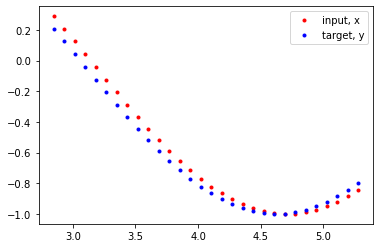

In [17]:
# how many time steps/data pts are in one batch of data
seq_length = 75

# generate evenly spaced data pts
time_steps = np.linspace(0, 2 * np.pi, seq_length + 1)
sin_serie = np.sin(time_steps)

window_size = 15

time_steps = create_inout_sequences(time_steps, window_size)
sin_serie = create_inout_sequences(sin_serie, window_size)

sample = np.random.choice( range(len(time_steps)) )
print(f"sample: {sample}")
print(f"total tuples: {len(time_steps)}")

input_ = sin_serie[ sample ][0]
target_ = sin_serie[ sample ][1]

# display the data
plt.plot(time_steps[ sample ][0], input_, 'r.', label='input, x') # x
plt.plot(time_steps[ sample ][0], target_, 'b.', label='target, y') # y

plt.legend(loc='best')
plt.show()

In [18]:
""" Define the RNN """

class RNN(nn.Module):
    
    """
    input_size: the size of the input
    hidden_dim: the number of features in the RNN output and in the hidden state
    n_layers: the number of layers that make up the RNN, tipically 1-3; greater than 1 means that you will create a stacked RNN
    batch_first: wheter or not the input/output of the RNN will have the batch size as the first dimension (batch_size, seq_length, hidden_dim)
    """
    
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        
        super(RNN, self).__init__()
        
        self.hidden_dim = hidden_dim

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)  
        
        # get final output 
        output = self.fc(r_out)
        
        return output, hidden

In [19]:
# test that dimensions are as expected
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=10, n_layers=2)

test_input = torch.Tensor( np.resize(input_, (len(input_), 1)) ).unsqueeze(0)
print('Input size: ', test_input.size())

# test out rnn sizes
test_out, test_h = test_rnn(test_input, None)

print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

Input size:  torch.Size([1, 30, 1])
Output size:  torch.Size([30, 1])
Hidden state size:  torch.Size([2, 1, 10])


In [20]:
# decide on hyperparameters
input_size=1 
output_size=1
hidden_dim=32
n_layers=1

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [21]:
# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

In [22]:
# train the RNN
def train(rnn, print_every):
    
    # initialize the hidden state
    hidden = None      
    
    for t in range(len(sin_serie)):
        
        input_ = sin_serie[ t ][0]
        target_ = sin_serie[ t ][1]
        
        # convert data into Tensors
        input_tensor = torch.Tensor( np.resize(input_, (len(input_), 1)) ).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        target_tensor = torch.Tensor( np.resize(target_, (len(input_), 1)) )
        
        # outputs from the rnn
        prediction, hidden = rnn(input_tensor, hidden)
        
        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data
        
        # calculate the loss
        loss = criterion(prediction, target_tensor)
        
        # zero gradients
        optimizer.zero_grad()
        
        # perform backprop and update weights
        loss.backward()
        optimizer.step()
        
        # display loss and predictions
        if t%print_every == 0:
            
            print('Loss: ', loss.item())
            plt.plot(time_steps[ t ][0], input_, 'r.', label='input') # input
            plt.plot(time_steps[ t ][0], target_, 'b.', label='target') # target
            plt.plot(time_steps[ t ][0], prediction.data.numpy().flatten(), 'g.', label='predicted') # predicted
            plt.show()
            
    return rnn

Loss:  0.5318926572799683


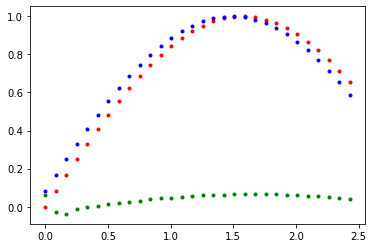

Loss:  0.10939078778028488


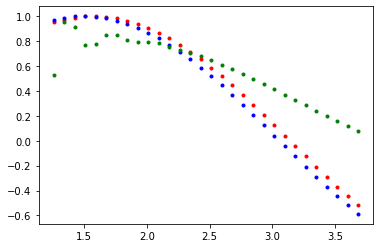

Loss:  0.015952173620462418


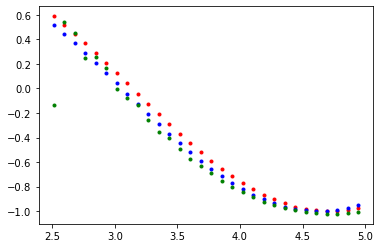

Loss:  0.017685089260339737


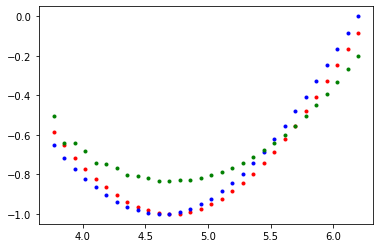

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [23]:
n_steps = 15
train(rnn, n_steps)